In [1]:
import os
import subprocess
import sys
import autograd.numpy as np
import itertools
import json
from tqdm import tqdm
from IPython.display import display, HTML
import time
import copy
from collections import namedtuple
from functools import partial
import matplotlib.pyplot as plt
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )
%load_ext autoreload
%autoreload 2
display(HTML("<style>.container { width:100% !important; }</style>"))

# This notebook will look at the convergence rate for different kinds of graphs
\*Even though gibbs isn't the best choice for getting a good marginal value, will include the plot of the marginal values that are sampled anyway

In [2]:
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior
from GenModels.GM.Models.DiscreteGraphModels import *
from GenModels.GM.States.GraphicalMessagePassing import *

In [3]:
graphs = []
for _ in range( 50 ):
    line = DataGraph()
    for i in range( 1, 30 ):
        line.addEdge( parents=[ i-1 ], children=[ i ] )
    graphs.append( ( line, np.array( [] ) ) )

In [4]:
graphs = [ ( graph1(), np.array( [] ) ),
           ( graph2(), np.array( [] ) ),
           ( graph3(), np.array( [] ) ),
           ( graph4(), np.array( [] ) ),
           ( graph5(), np.array( [] ) ),
           ( graph6(), np.array( [] ) ),
           ( graph7(), np.array( [] ) ),
           cycleGraph1(),
           cycleGraph2(),
           cycleGraph3(),
           cycleGraph7(),
           cycleGraph8(),
           cycleGraph10(),
           cycleGraph11(),
           cycleGraph12() ]
graphs = graphs*3

In [5]:
total_nodes = sum( [ len( g.nodes ) for g, _ in graphs ] )
print( total_nodes )

348


In [6]:
initial_shape, transition_shapes, emission_shape = GHMM.parameterShapes( graphs, d_latent=3, d_obs=4 )
initial_priors = np.ones( initial_shape )
transition_priors = [ np.ones( shape ) for shape in transition_shapes ]
emission_prior = np.ones( emission_shape )

In [7]:
true_model = GHMM( priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
for i, ( graph, fbs ) in enumerate( graphs ):
    true_model.setGraphs( [ ( graph, fbs ) ] )
    _, data = true_model.sampleStates()
    graph.setNodeData( data.keys(), data.values() )

In [8]:
print( true_model.params.initial_dist.pi )
print( [ dist.pi for dist in true_model.params.transition_dists ] )
print( true_model.params.emission_dist.pi )

[0.20714607 0.04053327 0.75232065]
[array([[0.20367059, 0.57957999, 0.21674941],
       [0.01569676, 0.36075754, 0.6235457 ],
       [0.80639984, 0.15746988, 0.03613028]]), array([[[0.33454559, 0.4755289 , 0.18992551],
        [0.09345248, 0.82159267, 0.08495485],
        [0.3895778 , 0.55134663, 0.05907557]],

       [[0.01468719, 0.92997372, 0.05533909],
        [0.64430633, 0.22007167, 0.135622  ],
        [0.84460784, 0.07579987, 0.07959229]],

       [[0.8180041 , 0.07813101, 0.10386489],
        [0.70121744, 0.13619973, 0.16258283],
        [0.28775266, 0.43441004, 0.2778373 ]]]), array([[[[0.14194463, 0.10820545, 0.74984992],
         [0.2616434 , 0.60321395, 0.13514265],
         [0.43329075, 0.18370997, 0.38299928]],

        [[0.64338023, 0.10982804, 0.24679173],
         [0.34523428, 0.00145794, 0.65330778],
         [0.14729972, 0.26684061, 0.58585967]],

        [[0.52194879, 0.26028224, 0.21776897],
         [0.03348695, 0.77034109, 0.19617196],
         [0.36427847, 0.33

# Test 1 - Deep graphs without cycles

In [9]:
# em_model    = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
# gibbs_model = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='Gibbs' )
# cavi_model  = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='CAVI' )
# svi_model   = GHMM( graphs, priors=( initial_priors, transition_priors, emission_prior ), method='SVI', step_size=0.1, minibatch_size=1 )

In [10]:
# values = []
# it = np.arange( 10 )
# for _ in it:
#     em_marginal    = em_model.fitStep()
#     gibbs_marginal = gibbs_model.fitStep( return_marginal=True )
#     elbo_cavi      = cavi_model.fitStep()
#     elbo_svi       = svi_model.fitStep()
#     values.append( [ em_marginal, gibbs_marginal, elbo_cavi, elbo_svi ] )

#     print( values[ -1 ] )

In [11]:
# y1, y2, y3, y4 = zip( *values )

In [12]:
# plt.plot( it[ :10 ], y1[ :10 ], color='red', label='em' )
# plt.plot( it[ :10 ], y2[ :10 ], color='blue', label='gibbs' )
# plt.plot( it[ :10 ], y3[ :10 ], color='green', label='elbo' )
# plt.plot( it[ :10 ], y4[ :10 ], color='purple', label='svi' )
# plt.show()

In [13]:
svae = GSVAE( graphs[ :3 ], priors=( initial_priors, transition_priors ), d_obs=4 )

In [19]:
losses = svae.fit()

/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in cosh
  return f_raw(*args, **kwargs)
/home/eddie/anaconda3/envs/GenModel/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:88: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh,   lambda ans, x : lambda g: g / anp.cosh(x) **2)


i 0 loss Autograd ArrayBox with value 853.8590404525322
i 25 loss Autograd ArrayBox with value 1261.6926081375484
i 50 loss Autograd ArrayBox with value 794.0822327009332
i 75 loss Autograd ArrayBox with value 548.0167538115778
i 100 loss Autograd ArrayBox with value 774.79616737788
i 125 loss Autograd ArrayBox with value 1361.3097288673096
i 150 loss Autograd ArrayBox with value 916.5748819669153
i 175 loss Autograd ArrayBox with value 1496.144135524787
i 200 loss Autograd ArrayBox with value 1236.237102738011
i 225 loss Autograd ArrayBox with value 1416.601385953277
i 250 loss Autograd ArrayBox with value 1061.7158627538406
i 275 loss Autograd ArrayBox with value 873.3144886290456
i 300 loss Autograd ArrayBox with value 1686.0132410051215
i 325 loss Autograd ArrayBox with value 1070.1889043470064
i 350 loss Autograd ArrayBox with value 1692.1715168223493
i 375 loss Autograd ArrayBox with value 1585.8738382770853
i 400 loss Autograd ArrayBox with value 959.8534392630127
i 425 loss Aut

In [15]:
assert 0

AssertionError: 

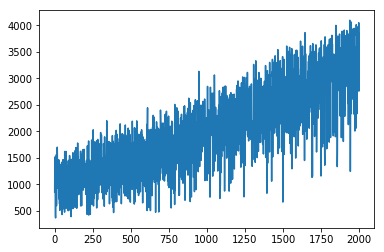

In [23]:
plt.plot( np.arange( len( losses ) ), np.array( [ l._value for l in losses ] ) )

In [ ]:
y = np.random.choice( 5, 5 )

In [ ]:
one_hot = np.zeros( ( y.shape[ 0 ], 5 ) )
one_hot[ np.arange( 5 ), y ] = 1

In [ ]:
one_hot

In [ ]:
y[ None ] + one_hot

In [ ]:
from scipy.stats import multivariate_normal, invwishart
import autograd.numpy as np
from autograd import grad

In [ ]:
mu = np.random.random( 2 )
sigma = invwishart.rvs( scale=np.eye( 2 ), df=5 )

def sample( mu, sigma ):
    sigma_chol = np.linalg.cholesky( sigma )
    noise = multivariate_normal.rvs( mean=np.zeros_like( mu ), cov=np.eye( mu.shape[ 0 ] ), size=1 )
    if( noise.ndim == 1 ):
        noise = noise[ None ]
    print( noise )
    return mu + np.einsum( 'ij,tj->ti', sigma_chol, noise )
    

In [ ]:
mine = sample( mu, sigma )

In [ ]:
tru = multivariate_normal.rvs( mean=mu, cov=sigma, size=100000 )

In [ ]:
plt.scatter( tru[ :, 0 ], tru[ :, 1 ], color='blue' )
plt.scatter( mine[ :, 0 ], mine[ :, 1 ], color='red' )

In [ ]:
def blah( mu ):
    x = np.linalg.solve( sigma, mu )
    return np.sum( x )

In [ ]:
N = 5
mu = np.random.random( ( 5, 5 ) )
sigma = invwishart.rvs( scale=np.eye( 5 ), df=N+1 )
grad( blah )( mu )

In [ ]:
np.linalg.solve( sigma, mu )

In [ ]:
ans = []
for m in mu:
    ans.append( np.linalg.solve( sigma.T, m ) )

In [ ]:
np.array( ans ).T 

In [ ]:
assert 0

In [ ]:
groups = [ 0, 1, 2 ]
d_latents = dict( zip( groups, [ 2, 3, 4 ] ) )
d_obs = 4

In [ ]:
def graphToGroupGraph( graphs, dataPerNode, groupPerNode, with_fbs=False, random_latent_states=False, d_latents=None ):
    assert isinstance( graphs, list )
    group_graphs = []
    for graph in graphs:

        if( with_fbs ):
            if( not isinstance( graph, Graph ) ):
                graph, fbs = graph
            else:
                graph, fbs = graph, np.array( [] )

        data = [ ( node, dataPerNode( node ) ) for node in graph.nodes ]
        group = [ ( node, groupPerNode( node ) ) for node in graph.nodes ]
        group_graph = GroupGraph.fromGraph( graph, data, group )

        if( random_latent_states ):
            assert d_latents is not None
            for node in group_graph.nodes:
                group = group_graph.groups[ node ]
                possible_latent_states = np.array( list( set( np.random.choice( np.arange( d_latents[ group ] ), d_latents[ group ] - 1 ).tolist() ) ) )
                group_graph.setPossibleLatentStates( node, possible_latent_states )

        if( with_fbs ):
            group_graphs.append( ( group_graph, fbs ) )
        else:
            group_graphs.append( group_graph )
    return group_graphs

def dataPerNode( node ):
    return Categorical.generate( D=d_obs, size=1 )
def groupPerNode( node ):
    return Categorical.generate( D=len( groups ) )

group_graphs = graphToGroupGraph( graphs, dataPerNode, groupPerNode, with_fbs=True )

In [ ]:
shapes = GroupGHMM.parameterShapes( group_graphs, d_latents={ 0:2, 1:3, 2:4 }, d_obs=4, groups=[ 0, 1, 2 ] )
initial_shapes, transition_shapes, emission_shapes = shapes

In [ ]:
initial_priors = dict( ( group, np.ones( shape ) ) for group, shape in initial_shapes.items() )
transition_priors = dict( ( group, [ np.ones( shape ) for shape in shapes ] ) for group, shapes in transition_shapes.items() )
emission_prior = dict( ( group, np.ones( shape ) ) for group, shape in emission_shapes.items() )

In [ ]:
true_model = GroupGHMM( priors=( initial_priors, transition_priors, emission_prior ), method='EM' )

In [ ]:
for i, ( graph, fbs ) in enumerate( group_graphs ):
    true_model.setGraphs( [ ( graph, fbs ) ] )
    _, data = true_model.sampleStates()
    graph.setNodeData( data.keys(), data.values() )

In [ ]:
em_model    = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='EM' )
gibbs_model = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='Gibbs' )
cavi_model  = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='CAVI' )
svi_model   = GroupGHMM( group_graphs, priors=( initial_priors, transition_priors, emission_prior ), method='SVI', step_size=0.1, minibatch_size=1 )

In [ ]:
cavi_model.fitStep()

In [ ]:
cavi_model.fitStep()

# Test 2 - Wide graphs without cycles

# Test 3 - Deep graphs with cycles

# Test 4 - Wide graphs with cycles